In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle
import math


seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

torch.set_default_tensor_type(torch.DoubleTensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, embedding_size=None):
        super(MLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            linear_list.append(nn.Linear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        self.shp = shp

    def forward(self, x, intervention_layer=0):
        shp = x.shape
        f = torch.nn.SiLU()
        acts = []
        acts.append(x.clone())
        for i in range(self.depth-1):
            if i >= intervention_layer:
                x = f(self.linears[i](x))
            acts.append(x.clone())
        x = self.linears[-1](x)
        acts.append(x.clone())
        return x, acts
    
    

betass = [(0.0, 0.0), (0.9, 0.999)]

betas_id = [0,1]
wds = [0.00,0.03]

results = {}

jj = 0

for beta_id in betas_id:
    
    for wd in wds:
        print(f'jj={jj}')
        
        seed = 0
        np.random.seed(seed)
        torch.manual_seed(seed)

        ### create model ###
        p = 59
        d = 128
        in_dim = 2*d
        out_dim = p

        shp = [in_dim, 100, 100, out_dim]
        model = MLP(shp=shp, embedding_size=(p, d)).to(device)

        ### create dataset ###

        x = np.arange(p)
        y = np.arange(p)
        XX, YY = np.meshgrid(x, y)
        data_id = np.transpose([XX.reshape(-1,), YY.reshape(-1,)])
        labels = (data_id[:,0] + data_id[:,1]) % p
        labels = torch.tensor(labels, dtype=torch.long)
        fraction = 0.8
        train_num = int(p**2*fraction)
        test_num = p**2 - train_num

        train_id = np.random.choice(p**2,train_num,replace=False)
        test_id = np.array(list(set(np.arange(p**2)) - set(train_id)))

        def get_data(id_):
            global labels
            inputs = torch.cat([model.embedding[data_id[id_][:,0]], model.embedding[data_id[id_][:,1]]], dim=1)
            return inputs.clone(), labels[id_].clone()


    
        ### train ###
        #wd = 0.02
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=wd, betas=betass[beta_id])
        steps = 10001
        log = 200
        swap_log = 20000
        plot_log = 200

        train_accs = []
        test_accs = []
        train_losses = []
        test_losses = []

        for step in range(steps):

            CEL = nn.CrossEntropyLoss()

            optimizer.zero_grad()


            inputs_train, labels_train = get_data(train_id)
            labels_train = labels_train.to(device)
            pred, acts  = model(inputs_train)
            loss = CEL(pred, labels_train)
            acc = torch.mean((torch.argmax(pred, dim=1) == labels_train).float())

            inputs_test, labels_test = get_data(test_id)
            labels_test = labels_test.to(device)
            pred_test, acts = model(inputs_test)
            loss_test = CEL(pred_test, labels_test)
            acc_test = torch.mean((torch.argmax(pred_test, dim=1) == labels_test).float())

            total_loss = loss
            total_loss.backward()
            optimizer.step()

            train_losses.append(loss.detach().numpy())
            test_losses.append(loss_test.detach().numpy())

            train_accs.append(acc.detach().numpy())
            test_accs.append(acc_test.detach().numpy())


            if step % log == 0:
                print("step = %d | total loss: %.2e | train loss: %.2e | test loss %.2e | train acc: %.2e | test acc: %.2e "%(step, total_loss.cpu().detach().numpy(), loss.cpu().detach().numpy(), loss_test.cpu().detach().numpy(), acc.cpu().detach().numpy(), acc_test.cpu().detach().numpy()))

        results[f'trainloss_wd_{wd}_betaid_{beta_id}'] = np.array(train_losses)
        results[f'testloss_wd_{wd}_betaid_{beta_id}'] = np.array(test_losses)
        results[f'trainacc_wd_{wd}_betaid_{beta_id}'] = np.array(train_accs)
        results[f'testacc_wd_{wd}_betaid_{beta_id}'] = np.array(test_accs)
        
        jj += 1

jj=0
step = 0 | total loss: 4.08e+00 | train loss: 4.08e+00 | test loss 4.08e+00 | train acc: 2.05e-02 | test acc: 2.01e-02 
step = 200 | total loss: 8.46e-03 | train loss: 8.46e-03 | test loss 1.50e+00 | train acc: 9.98e-01 | test acc: 7.32e-01 
step = 400 | total loss: 2.64e-03 | train loss: 2.64e-03 | test loss 1.26e+00 | train acc: 9.99e-01 | test acc: 8.67e-01 
step = 600 | total loss: 1.05e-11 | train loss: 1.05e-11 | test loss 1.29e+00 | train acc: 1.00e+00 | test acc: 9.08e-01 
step = 800 | total loss: 3.41e-12 | train loss: 3.41e-12 | test loss 1.28e+00 | train acc: 1.00e+00 | test acc: 9.11e-01 
step = 1000 | total loss: 2.21e-12 | train loss: 2.21e-12 | test loss 1.27e+00 | train acc: 1.00e+00 | test acc: 9.11e-01 
step = 1200 | total loss: 1.68e-12 | train loss: 1.68e-12 | test loss 1.27e+00 | train acc: 1.00e+00 | test acc: 9.11e-01 
step = 1400 | total loss: 1.37e-12 | train loss: 1.37e-12 | test loss 1.26e+00 | train acc: 1.00e+00 | test acc: 9.11e-01 
step = 1600 | tota

In [3]:
np.savez('./results/grokking', **results)

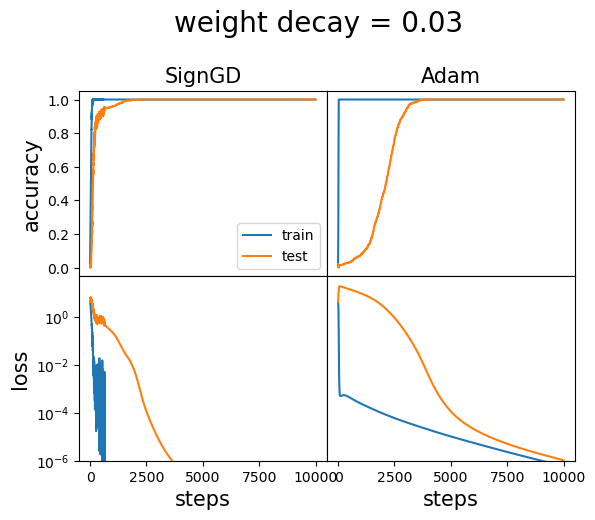

In [22]:
loaded_data = np.load('./results/grokking.npz')
data = dict(loaded_data)

wd = 0.03

fontsize=15

plt.subplot(2,2,1)
betaid = 0
plt.plot(data[f'trainacc_wd_{wd}_betaid_{betaid}'])
plt.plot(data[f'testacc_wd_{wd}_betaid_{betaid}'])
plt.ylim(-0.05,1.05)
plt.title('SignGD', fontsize=fontsize)
plt.ylabel('accuracy', fontsize=fontsize)
plt.xticks([])
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,2,2)
betaid = 1
plt.plot(data[f'trainacc_wd_{wd}_betaid_{betaid}'])
plt.plot(data[f'testacc_wd_{wd}_betaid_{betaid}'])
plt.ylim(-0.05,1.05)
plt.yticks([])
plt.title('Adam', fontsize=fontsize)
plt.xticks([])

plt.subplot(2,2,3)
betaid = 0
plt.plot(data[f'trainloss_wd_{wd}_betaid_{betaid}'])
plt.plot(data[f'testloss_wd_{wd}_betaid_{betaid}'])
plt.ylim(1e-6,50)
plt.yscale('log')
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('steps', fontsize=fontsize)


plt.subplot(2,2,4)
betaid = 1
plt.plot(data[f'trainloss_wd_{wd}_betaid_{betaid}'])
plt.plot(data[f'testloss_wd_{wd}_betaid_{betaid}'])
plt.ylim(1e-6,50)
plt.yscale('log')
plt.yticks([])
plt.xlabel('steps', fontsize=fontsize)

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.suptitle(f'weight decay = {wd}', fontsize=20, y=1.05)

plt.savefig(f'./plot/grokking_wd_{wd}.pdf', bbox_inches='tight')

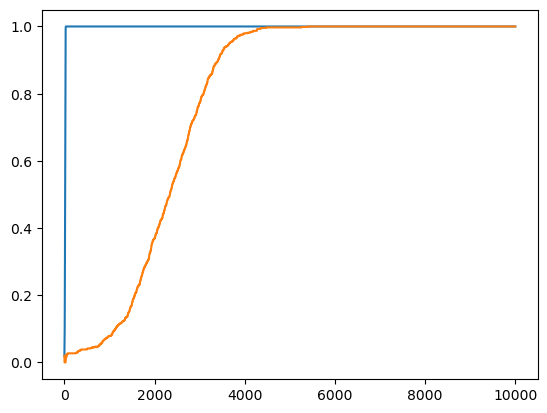

In [2]:
wd = 0.03
beta_id = 0
train_accs = results

plt.plot(train_accs)
plt.plot(test_accs)